In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F




import sys
sys.path.append('../Pyfiles')
# Pull in the helper files.
from ImageRead import *

import qiskit
from qiskit import transpile, assemble
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit import BasicAer, Aer, execute
from qiskit.quantum_info import state_fidelity
from qiskit.visualization import *
from qiskit.quantum_info.operators import Operator


In [211]:
pathY=r'..\\dataset\\Labels-Binary\\storm\\'
pathN=r'..\\dataset\\Labels-Binary\\No-storm\\'
nameN='no_storm'
nameY='storm'
targetY=[imageResize(callImage(i+1,pathY,nameY),16) for i in range(25)]
targetN=[imageResize(callImage(i+1,pathN,nameN),16) for i in range(25)]
target_combine = targetY+targetN

In [212]:
pathY=r'..\\dataset\\Original\\storm\\'
pathN=r'..\\dataset\\Original\\No-storm\\'
nameN='no_storm'
nameY='storm'
inputY=[imageResize(callImage(i+1,pathY,nameY),16) for i in range(25)]
inputN=[imageResize(callImage(i+1,pathN,nameN),16) for i in range(25)]
input_combine = inputY+inputN

In [213]:
import random
np.random.seed(0)
idx=np.array([int(i) for i in range(50)]).flatten()

np.random.shuffle(idx)

dataInput = list(input_combine[i] for i in idx )
dataTarget = list( imageBinarize(input_combine[i]) for i in idx )


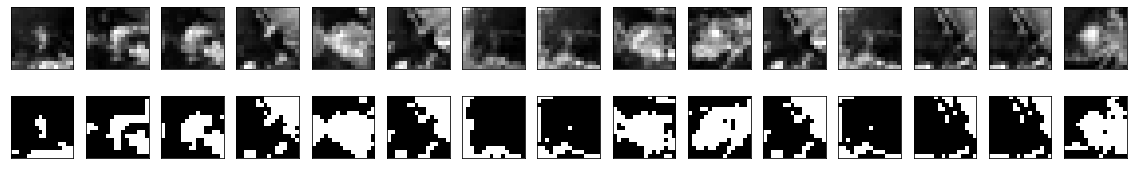

In [214]:
n_samples_show = 15
fig, axes = plt.subplots(nrows=2, ncols=n_samples_show, figsize=(20, 3))

for i in range(15):

    axes[0,i].imshow(dataInput[i], cmap='gray')
    axes[0,i].set_xticks([])
    axes[0,i].set_yticks([])

    axes[1,i].imshow(dataTarget[i], cmap='gray')
    axes[1,i].set_xticks([])
    axes[1,i].set_yticks([])

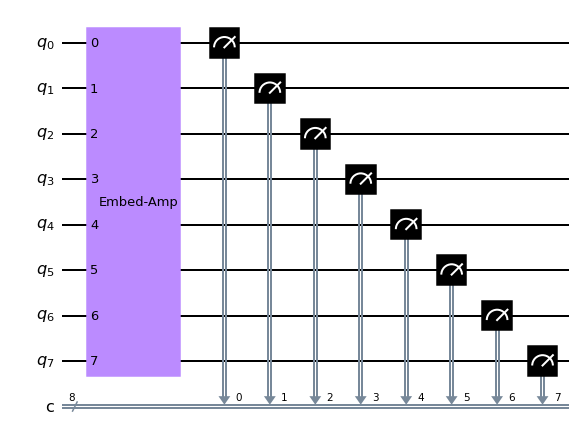

In [224]:
nqubits=8
qr = QuantumRegister(nqubits,'q')
cr = ClassicalRegister(nqubits,'c')

qc = QuantumCircuit(qr, name='Embed-Amp')

qc.initialize(normlaizeData(dataInput[0]), range(nqubits))
my_inst = qc.to_instruction()


my_circuit = QuantumCircuit(qr,cr)
my_circuit.append(my_inst, range(nqubits))
my_circuit.measure(qr[:],cr[:])
my_circuit.draw(output='mpl')

# Amplitude Encoding

In [46]:
def normlaizeData(data):
    #Create Array of pixel value
    testdata=data
    arr_data=testdata.flatten()/max(testdata.flatten());
    encoding_data= np.array([np.round(x,6) for x in arr_data]);
    sum_const=np.sqrt(sum(encoding_data*encoding_data))
    encoding_norm=encoding_data/sum_const
    return encoding_norm


In [102]:
def buildCicuit(encoding):
    qr = QuantumRegister(nqubits)
    cr = ClassicalRegister(nqubits)

    qc = QuantumCircuit(qr, name='Initialization')
    qc.initialize(encoding, range(nqubits))
    my_inst = qc.to_instruction()


    my_circuit = QuantumCircuit(qr,cr)
    my_circuit.append(my_inst, range(nqubits))
    my_circuit.measure(qr[:],cr[:])
    return my_circuit


In [103]:
def runCircuit(circuit):
    backend = Aer.get_backend('qasm_simulator')
    job = execute(circuit, backend, shots=nshot)
    result = job.result()
    count =result.get_counts()
    return count

In [104]:
from toolz import partition

def countBitstring(count):
    f=[]
    for i in range(2**nqubits):
        if format(i, '#010b')[2:10] in count:
            f.append(count[format(i, '#010b')[2:10]])
        else:
            f.append(0)
    return np.array(list(f))
    

In [105]:
def imgize(listdata):
    out_img=np.array(list(partition(16, listdata)));
    return out_img/max(listdata)

In [106]:
def findCutOff(img,target):
    f=[]
    for i in range(100):
        f.append(1-sum(sum((abs(target - 1.0 * (img > i/100)))/(2**nqubits))))
    mx=max(f);
    index=f.index(mx);
    rethres=1.0 * (img > index/100)
    return rethres

In [107]:
def accuracy(img,target):
    acc=1-sum(sum((abs(target-img))))/(2**nqubits)
    return acc

In [135]:
def AmpltudeEncoding(input,target):
    encoding_norm=normlaizeData(input)
    qc=buildCicuit(encoding_norm)
    count = runCircuit(qc)
    listcount=countBitstring(count)
    img=imgize(listcount)

    acc=accuracy(img,target)
    return img,acc

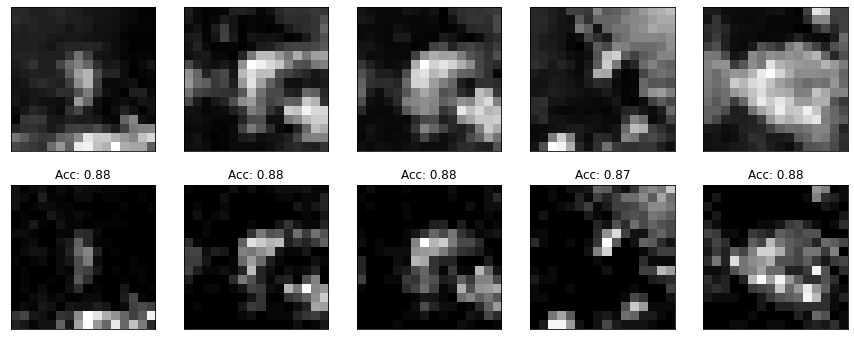

In [136]:
nqubits=8;
nshot=1000;
n_samples_show = 5
fig, axes = plt.subplots(nrows=2, ncols=n_samples_show, figsize=(15, 6))

for i in range(5):

    axes[0,i].imshow(dataInput[i], cmap='gray')
    axes[0,i].set_xticks([])
    axes[0,i].set_yticks([])

    axes[1,i].imshow(AmpltudeEncoding(dataInput[i],dataTarget[i])[0], cmap='gray')
    axes[1,i].set_xticks([])
    axes[1,i].set_yticks([])
    axes[1,i].set_title("Acc: {}".format(round(AmpltudeEncoding(dataInput[0],dataTarget[0])[1],2)))

# Amplitude Filter

In [108]:
from toolz import partition

#filter is in %
def countBitstringFilter(count,filter):
    f=[]
    thrs = nshot*filter
    for i in range(2**nqubits):
        if format(i, '#010b')[2:10] in count:
            if count[format(i, '#010b')[2:10]] > thrs:
                f.append(1)
            else:
                f.append(0)        
        else:
            f.append(0)
    return np.array(list(f))

In [109]:
def AmpltudeEncodingFilter(input,filter):
    encoding_norm=normlaizeData(input)
    qc=buildCicuit(encoding_norm)
    count = runCircuit(qc)
    listcount=countBitstringFilter(count,filter)
    img=imgize(listcount)
    return img

<ipython-input-105-f0bfede74fb8>:3: RuntimeWarning: invalid value encountered in true_divide
  return out_img/max(listdata)
C:\Users\Saesun Kim\anaconda3\envs\qiskit\lib\site-packages\matplotlib\image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
C:\Users\Saesun Kim\anaconda3\envs\qiskit\lib\site-packages\matplotlib\image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


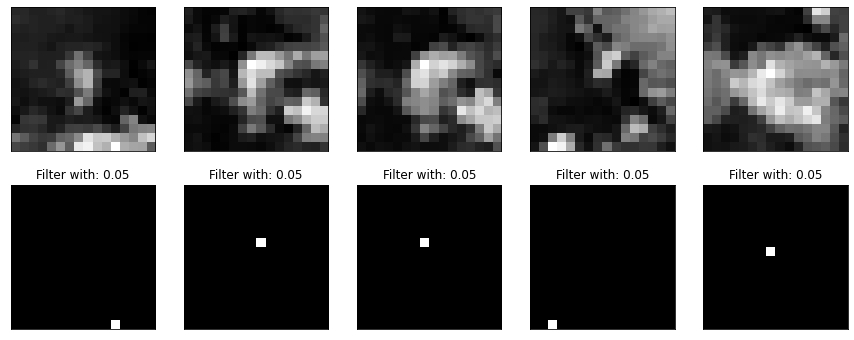

In [163]:
nqubits=8;
nshot=10000;
n_samples_show = 5
fig, axes = plt.subplots(nrows=2, ncols=n_samples_show, figsize=(15, 6))
filter= 0.05

filterlist=[j for j in range(50)]
for j in filterlist:
    for i in range(5):

        axes[0,i].imshow(dataInput[i], cmap='gray')
        axes[0,i].set_xticks([])
        axes[0,i].set_yticks([])

        axes[1,i].imshow(AmpltudeEncodingFilter(dataInput[i],round(0.001*(j+1),3)), cmap='gray')
        axes[1,i].set_xticks([])
        axes[1,i].set_yticks([])
        axes[1,i].set_title("Filter with: {}".format(round(0.001*(j+1),3)))
    fig.savefig("../result/AmplitudeFilter/Amplitude-filter-"+str(j)+".jpg")    

# Video

In [165]:
path=r'..\\dataset\\Original\\Videoframe\\video\\'

name='video-'
data=[imageResize(callImage(i+1,path,name),32) for i in range(100)]


In [195]:
#filter is in %
def countBitstringFilter32(count,filter):
    f=[]
    thrs = nshot*filter
    for i in range(2**nqubits):
        if format(i, '#012b')[2:12] in count:
            if count[format(i, '#012b')[2:12]] > thrs:
                f.append(1)
            else:
                f.append(0)        
        else:
            f.append(0)
    return np.array(list(f))

In [196]:
def imgize32(listdata):
    out_img=np.array(list(partition(32, listdata)));
    return out_img/max(listdata)

In [197]:
def AmpltudeEncodingFilter32(input,filter):
    encoding_norm=normlaizeData(input)
    qc=buildCicuit(encoding_norm)
    count = runCircuit(qc)
    listcount=countBitstringFilter32(count,filter)
    img=imgize32(listcount)
    return img

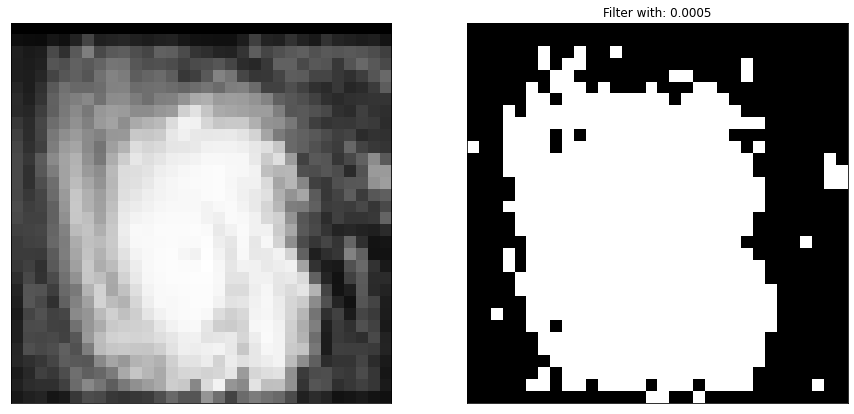

In [207]:
nqubits=10;
nshot=10000;
n_samples_show = 2
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(15, 15))
filter= 0.0005

for i in range(100):
    axes[0].imshow(data[i], cmap='gray')
    axes[0].set_xticks([])
    axes[0].set_yticks([])

    axes[1].imshow(AmpltudeEncodingFilter32(data[i],filter), cmap='gray')
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    axes[1].set_title("Filter with: {}".format(filter))

    fig.savefig("../result/Video-filtering/video-"+str(i)+".jpg")    


# Without Cutoff

In [17]:
def AmpltudeEncoding(input,target):
    encoding_norm=normlaizeData(input)
    qc=buildCicuit(encoding_norm)
    count = runCircuit(qc)
    listcount=countBitstring(count)
    img=imgize(listcount)
    imgf=1.0 * (img > 25/100)
    acc=accuracy(imgf,target)
    return imgf,acc

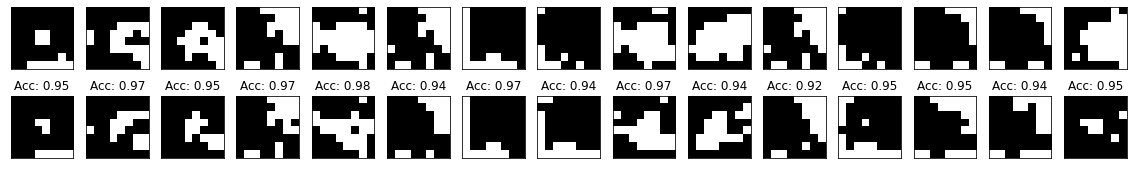

In [18]:
n_samples_show = 15
fig, axes = plt.subplots(nrows=2, ncols=n_samples_show, figsize=(20, 3))

for i in range(15):

    axes[0,i].imshow(dataTarget[i], cmap='gray')
    axes[0,i].set_xticks([])
    axes[0,i].set_yticks([])

    axes[1,i].imshow(AmpltudeEncoding(dataInput[i],dataTarget[i])[0], cmap='gray')
    axes[1,i].set_xticks([])
    axes[1,i].set_yticks([])
    axes[1,i].set_title("Acc: {}".format(round(AmpltudeEncoding(dataInput[0],dataTarget[0])[1],2)))

# Grover Search

In [19]:
np.pi*np.sqrt(64)/4

6.283185307179586

In [20]:
np.pi*np.sqrt(8)/4

2.221441469079183

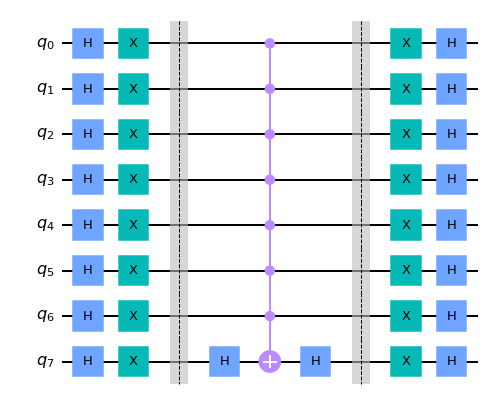

In [229]:
nqubits=8
qc = QuantumCircuit(nqubits)
# Apply transformation |s> -> |00..0> (H-gates)
for qubit in range(nqubits):
    qc.h(qubit)
# Apply transformation |00..0> -> |11..1> (X-gates)
for qubit in range(nqubits):
    qc.x(qubit)
# Do multi-controlled-Z gate
qc.barrier()
qc.h(nqubits-1)
qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
qc.h(nqubits-1)
qc.barrier()
# Apply transformation |11..1> -> |00..0>
for qubit in range(nqubits):
    qc.x(qubit)
# Apply transformation |00..0> -> |s>
for qubit in range(nqubits):
    qc.h(qubit)
# We will return the diffuser as a gate

qc.draw(output='mpl')

In [235]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "Diffuser"
    return U_s

In [273]:
def phaseFlipM(testdata):
    arr_data=testdata.flatten()/max(testdata.flatten());
    encoding_data= np.array([np.round(x,8) for x in arr_data]);
    sum_const=np.sqrt(sum(np.absolute(encoding_data) ** 2))
    encoding_norm=encoding_data/sum_const
    m=np.diag(np.exp(complex(0,1)*np.pi*encoding_norm))
    return m

In [398]:
path=r'..\\dataset\\Others\\'
name='P-'
imgdata=imageResize(callImage(2,path,name),8)
#Satellite images show Fort McMurray wildfire from space

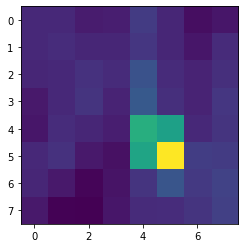

In [399]:
plt.imshow(imgdata)

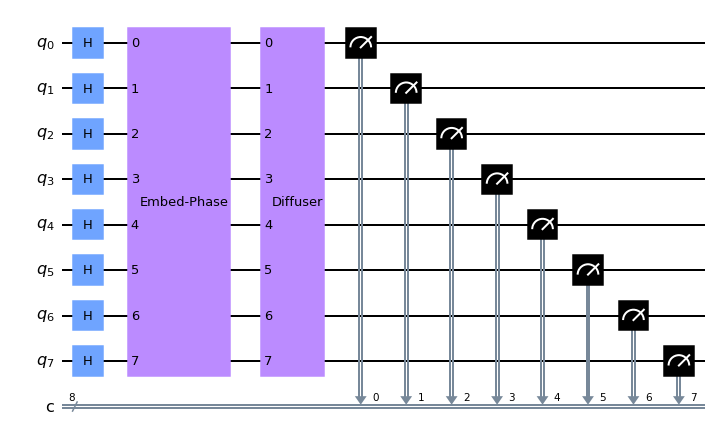

In [345]:
nqubits=8
qr = QuantumRegister(nqubits,'q')
cr = ClassicalRegister(nqubits,'c')
m = phaseFlipM(dataInput[1])
#Initilzation
qc = QuantumCircuit(qr, name='Embed-Phase')
#qc.initialize(desired_vector, [qr[0],qr[1],qr[2],qr[3],qr[4],qr[5]])
qc.unitary(m, range(nqubits), label='UI')

my_inst = qc.to_instruction()

#Grover Search
my_circuit = QuantumCircuit(qr,cr)
for qubit in range(nqubits):
    my_circuit.h(qubit)

for i in range(1):
    my_circuit.append(my_inst, range(nqubits))
    my_circuit.append(diffuser(nqubits), range(nqubits))

my_circuit.measure(qr[:],cr[:])
my_circuit.draw(output='mpl')

In [346]:
qr = QuantumRegister(nqubits)
cr = ClassicalRegister(nqubits)
m = phaseFlipM(np.array(dataTarget[0]))
#Initilzation
qc = QuantumCircuit(qr, name='UI')
#qc.initialize(desired_vector, [qr[0],qr[1],qr[2],qr[3],qr[4],qr[5]])
qc.unitary(m, range(nqubits), label='UI')

my_inst = qc.to_instruction()

#Grover Search
my_circuit = QuantumCircuit(qr,cr)
for qubit in range(nqubits):
    my_circuit.h(qubit)

for i in range(1):
    my_circuit.append(my_inst, range(nqubits))
    my_circuit.append(diffuser(nqubits), range(nqubits))

my_circuit.measure(qr[:],cr[:])
nshot=1000;

backend = Aer.get_backend('qasm_simulator')
job = execute(my_circuit, backend, shots=nshot)
result = job.result()
count =result.get_counts()
my_circuit.draw()

┌───┐┌─────┐┌───────────┐┌─┐                     
q18097_0: ┤ H ├┤0    ├┤0          ├┤M├─────────────────────
          ├───┤│     ││           │└╥┘┌─┐                  
q18097_1: ┤ H ├┤1    ├┤1          ├─╫─┤M├──────────────────
          ├───┤│     ││           │ ║ └╥┘┌─┐               
q18097_2: ┤ H ├┤2    ├┤2          ├─╫──╫─┤M├───────────────
          ├───┤│     ││           │ ║  ║ └╥┘┌─┐            
q18097_3: ┤ H ├┤3    ├┤3          ├─╫──╫──╫─┤M├────────────
          ├───┤│  UI ││  Diffuser │ ║  ║  ║ └╥┘┌─┐         
q18097_4: ┤ H ├┤4    ├┤4          ├─╫──╫──╫──╫─┤M├─────────
          ├───┤│     ││           │ ║  ║  ║  ║ └╥┘┌─┐      
q18097_5: ┤ H ├┤5    ├┤5          ├─╫──╫──╫──╫──╫─┤M├──────
          ├───┤│     ││           │ ║  ║  ║  ║  ║ └╥┘┌─┐   
q18097_6: ┤ H ├┤6    ├┤6          ├─╫──╫──╫──╫──╫──╫─┤M├───
          ├───┤│     ││           │ ║  ║  ║  ║  ║  ║ └╥┘┌─┐
q18097_7: ┤ H ├┤7    ├┤7          ├─╫──╫──╫──╫──╫──╫──╫─┤M├
          └───┘└─────┘└───────────┘ ║  ║  ║  ║  ║  ║  ║ └╥┘
 c1954: 8/══════════════════════════╩══╩══╩══╩══╩══╩══╩══╩═
                                    0  1  2  3  4  5  6  7

In [356]:
def grover(itr,data):
    qr = QuantumRegister(nqubits)
    cr = ClassicalRegister(nqubits)
    m = phaseFlipM(np.array(data))
    #Initilzation
    qc = QuantumCircuit(qr, name='UI')
    #qc.initialize(desired_vector, [qr[0],qr[1],qr[2],qr[3],qr[4],qr[5]])
    qc.unitary(m, range(nqubits), label='UI')

    my_inst = qc.to_instruction()

    #Grover Search
    my_circuit = QuantumCircuit(qr,cr)
    for qubit in range(nqubits):
        my_circuit.h(qubit)

    for i in range(itr):
        my_circuit.append(my_inst, range(nqubits))
        my_circuit.append(diffuser(nqubits), range(nqubits))

    my_circuit.measure(qr[:],cr[:])
    nshot=1000;

    backend = Aer.get_backend('qasm_simulator')
    job = execute(my_circuit, backend, shots=nshot)
    result = job.result()
    count =result.get_counts()
    return count

In [401]:
def countBitstring(count):
    f=[]
    for i in range(2**nqubits):
        if format(i, '#010b')[4:10] in count:
            f.append(count[format(i, '#010b')[4:10]])
        else:
            f.append(0)
    return np.array(list(f))

In [407]:
from collections import OrderedDict
from toolz import partition

def imigize1(count):
    countlist=countBitstring(count)
    out_img=np.array(list(partition(8, countlist)))/max(countlist);
    return out_img.squeeze()

In [404]:
np.pi*np.sqrt(64/6)/4

2.565099660323728

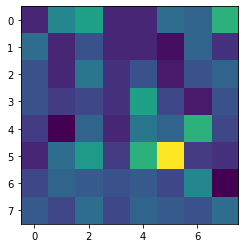

In [428]:
nqubits=6

plt.imshow(imigize1(grover(3,imgdata)))
